In [1]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
import string
import collections
import os

from nltk import word_tokenize, WordNetLemmatizer
from nltk.tokenize import*
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
data = pd.read_csv(".\dataset 2\dataset.csv")
data.head()

,Text
0,News: GRECCO-19 trial results reported by Spyr...
1,@WhiteHouse @trumprealtweets @Forbes @YahooNew...
2,@realDonaldTrump Record #covid19 cases! #VoteB...
3,@JanJan60206902 Don’t forget when trump shut d...
4,Is that Covid19 shit growing in new jersery or...


## Text Preprocessing

In [3]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [4]:
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [5]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [6]:
emoticons = emoticons_happy.union(emoticons_sad)

In [7]:
tokens_list = []

In [8]:
def clean_tweets(tweet):
    
    tweet = re.sub(r'@[A-Za-z0-9]+','',tweet)     
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'RT[\s]+','',tweet)
    tweet = re.sub(r'https?:\/\/\S+','',tweet)
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    
    #make a list of stopwords
    stopw = set(stopwords.words('english'))
    stopw.remove('not')
    stopw.remove('nor')

    #make word tokens
    tokenizer = RegexpTokenizer('[a-zA-Z]+')
    word_tokens = tokenizer.tokenize(tweet.lower())
     
    #remove stopwords    
    filtered_tweet = [w for w in word_tokens if not w in stopw]
    filtered_tweet = []
    
    #looping through conditions
    for w in word_tokens:

        #check tokens against stop words , emoticons and punctuations
        if w not in stopw and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
            
    tokens_list.append(filtered_tweet)
    return ' '.join(filtered_tweet)

In [9]:
filtered_tweets = []

for i in range(len(data)):
    filtered_tweets.append(clean_tweets(data["Text"][i]))
    
print(filtered_tweets)

['news grecco trial results reported spyridon deftereos co authors', 'time get real time call right need', 'record covid cases votebluetosaveamerica voteblue resignnowtrump', 'forget trump shut international travel covid democrats called x', 'covid shit growing new jersery not need answerss', 'one left behind covid response need support migrant workers priorities right', 'chairman adam schiff usa congress intelligence committee july covid usa wha', 'hey indoors covid', 'absolutely unnecessary divert time resources towards pvnarasimharao centenary celebrati', 'california closing many beaches going shutting indoor operations many busine', 'arizona governor shut order defies reason', 'countries across world particularly covid pandemic witnessing limits healthcar', 'many comments expectations senior teams communications including one north', 'tangina plss miss skin fucking household know word affection fu covid', 'arizona covid report confirmed cases daily cases confirmed deaths new deaths

In [10]:
tokens = np.array(tokens_list)
print(tokens.shape)
print(type(tokens))

(20001,)
<class 'numpy.ndarray'>


In [11]:
tweet_df = np.column_stack((filtered_tweets, tokens))

In [12]:
tweet_df.shape

(20001, 2)

In [13]:
tweet_df = pd.DataFrame(data=tweet_df,columns=['Text','Tokens'])
tweet_df.head()


,Text,Tokens
0,news grecco trial results reported spyridon de...,"[news, grecco, trial, results, reported, spyri..."
1,time get real time call right need,"[time, get, real, time, call, right, need]"
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ..."
3,forget trump shut international travel covid d...,"[forget, trump, shut, international, travel, c..."
4,covid shit growing new jersery not need answerss,"[covid, shit, growing, new, jersery, not, need..."


In [14]:
# finding polarity of text using textBlob

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

tweet_df['Polarity'] = tweet_df['Text'].apply(getPolarity)
tweet_df

,Text,Tokens,Polarity
0,news grecco trial results reported spyridon de...,"[news, grecco, trial, results, reported, spyri...",0.000000
1,time get real time call right need,"[time, get, real, time, call, right, need]",0.242857
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ...",0.000000
3,forget trump shut international travel covid d...,"[forget, trump, shut, international, travel, c...",0.000000
4,covid shit growing new jersery not need answerss,"[covid, shit, growing, new, jersery, not, need...",-0.031818
...,...,...,...
19996,closed garment workers test positive coronavir...,"[closed, garment, workers, test, positive, cor...",0.063636
19997,closed garment workers test positive coronavir...,"[closed, garment, workers, test, positive, cor...",0.063636
19998,coronavirus going away fact spiking dramatical...,"[coronavirus, going, away, fact, spiking, dram...",0.000000
19999,appreciate using data also basing ass,"[appreciate, using, data, also, basing, ass]",0.000000


In [15]:
tweet_df.shape

(20001, 3)

In [16]:
tweet_df.Polarity.unique()

array([ 0.        ,  0.24285714, -0.03181818, ...,  0.05833333,
        0.12222222, -0.15      ])

In [17]:
pos = []
neg = []
polarity = []
countp = 0
countn = 0
count = 0

for i in tweet_df.Polarity:
    if i < 0:
        polarity.append(0)
        pos.append(0)
        neg.append(1)
        countn += 1
    elif i >= 0:
        polarity.append(1)
        pos.append(1)
        neg.append(0)
        countp += 1
    

print(countp,countn)

16375 3626


In [18]:
tweet_df['Pos']= pos
tweet_df['Neg']= neg
tweet_df['Polarity'] = polarity

In [19]:
#clean data is ready with tokens and polarity

tweet_df.head()

,Text,Tokens,Polarity,Pos,Neg
0,news grecco trial results reported spyridon de...,"[news, grecco, trial, results, reported, spyri...",1,1,0
1,time get real time call right need,"[time, get, real, time, call, right, need]",1,1,0
2,record covid cases votebluetosaveamerica voteb...,"[record, covid, cases, votebluetosaveamerica, ...",1,1,0
3,forget trump shut international travel covid d...,"[forget, trump, shut, international, travel, c...",1,1,0
4,covid shit growing new jersery not need answerss,"[covid, shit, growing, new, jersery, not, need...",0,0,1


## Data visulisation

In [20]:
from wordcloud import WordCloud

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [23]:
neg_tweets = tweet_df[tweet_df.Polarity == 0]
neg_string = []
for t in neg_tweets.Text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


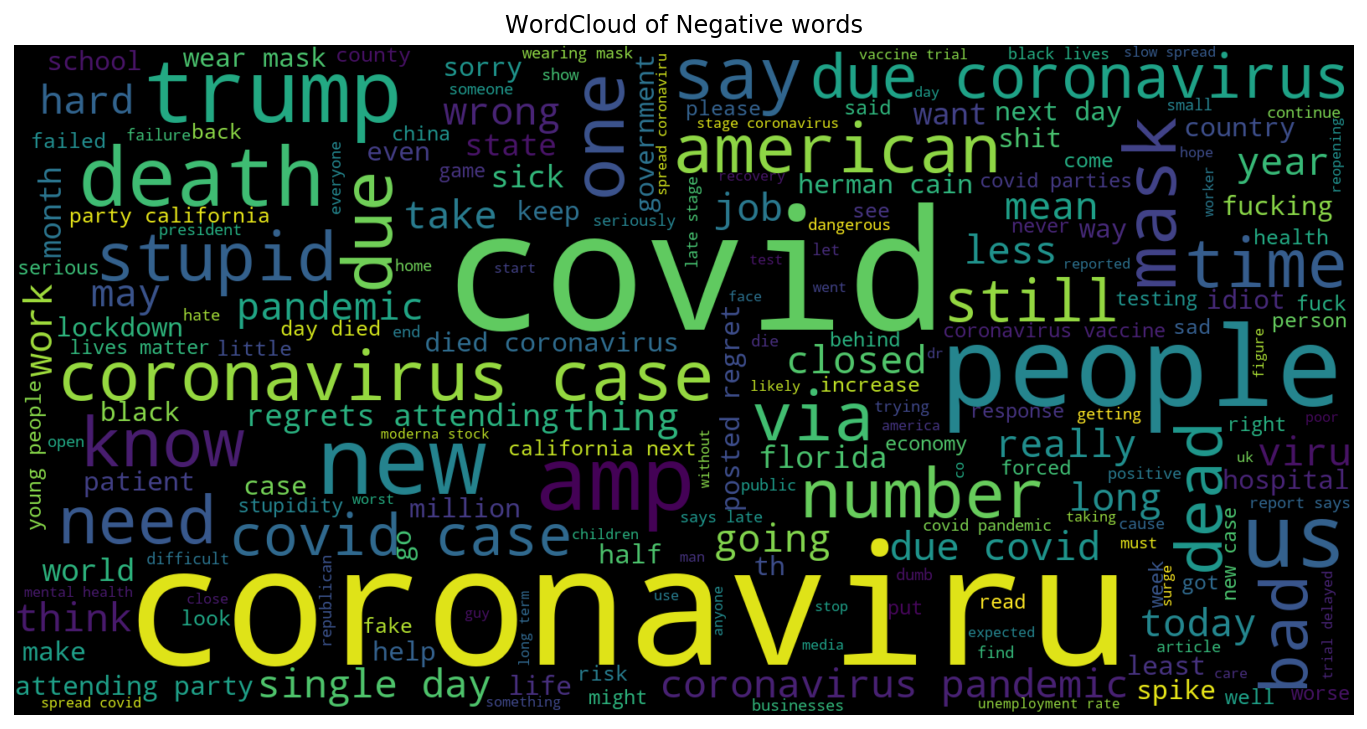

In [24]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Negative words")
plt.show()

In [25]:
pos_tweets = tweet_df[tweet_df.Polarity == 1]
pos_string = []
for t in pos_tweets.Text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

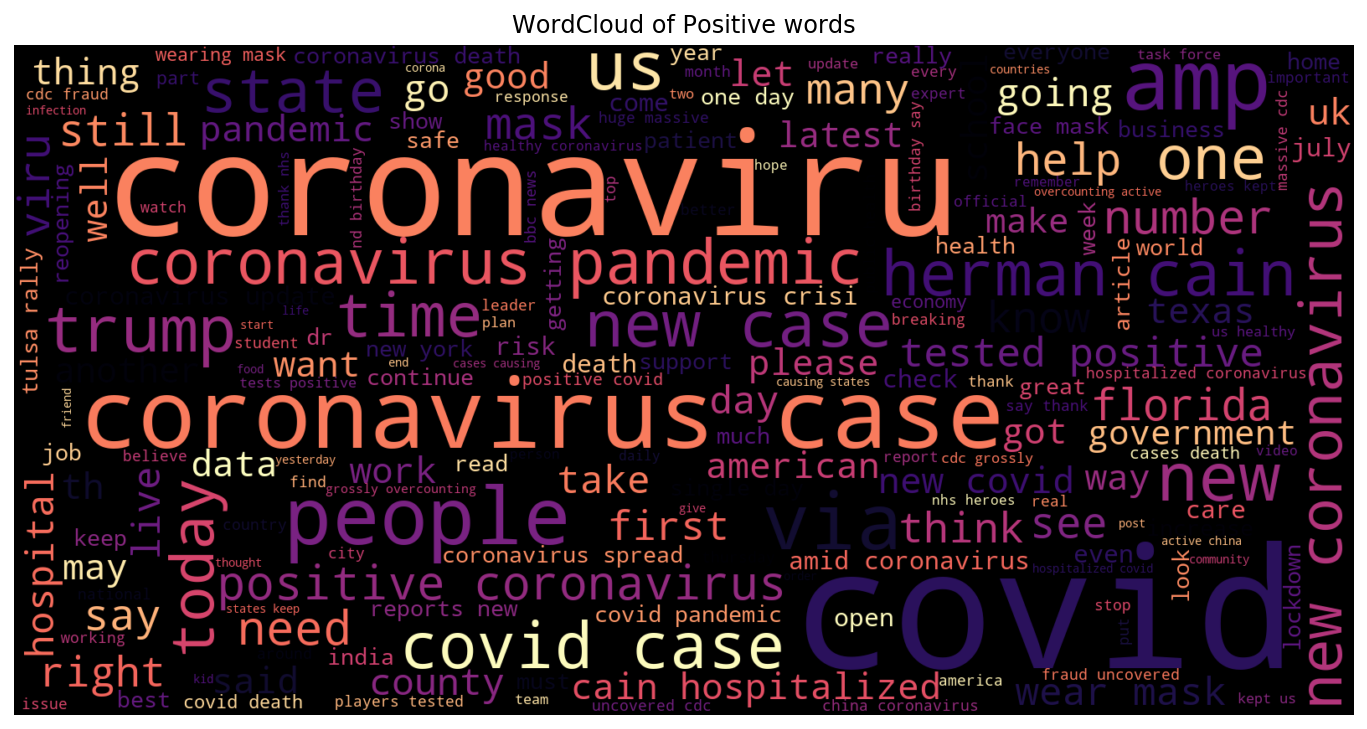

In [26]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Positive words")
plt.show()

### Splitting data into training data and test data

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
data_train, data_test = train_test_split(tweet_df,test_size=0.10,random_state=42)

In [29]:
# for training data

all_training_words = [word for tokens in data_train['Tokens'] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train['Tokens']]
training_vocab = sorted(list(set(all_training_words)))
print("Total words = %s " % (len(all_training_words)))
print("Vocabulary size = %s "%(len(training_vocab)))
print("Max sentence length = %s" % max(training_sentence_lengths))

Total words = 166711 
Vocabulary size = 18738 
Max sentence length = 24


In [30]:
# for test data

all_test_words = [word for tokens in data_test['Tokens'] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test['Tokens']]
test_vocab = sorted(list(set(all_test_words)))
print("Total words = %s " % (len(all_test_words)))
print("Vocabulary size = %s "%(len(test_vocab)))
print("Max sentence length = %s" % max(test_sentence_lengths))

Total words = 18632 
Vocabulary size = 5684 
Max sentence length = 17


In [31]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [32]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['Tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

Embeddings

In [33]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [34]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [36]:
tokenizer = Tokenizer(num_words=len(training_embeddings), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 18738 unique tokens.


In [37]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [38]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(18739, 300)


In [39]:

test_sequences = tokenizer.texts_to_sequences(data_test["Text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

## CNN model

In [40]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [41]:
label_names = ['Pos', 'Neg']

In [42]:
y_train = data_train[label_names].values

In [43]:
x_train = train_cnn_data
y_tr = y_train

In [44]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,len(list(label_names)))

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      5621700     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 200)      120200      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 200)      180200      embedding_1[0][0]                
____________________

In [45]:
# train cnn

num_epochs = 3
batch_size = 34


In [46]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 16200 samples, validate on 1800 samples
Epoch 1/3
16200/16200 [==============================] - 127s 8ms/step - loss: 0.4142 - acc: 0.8294 - val_loss: 0.2914 - val_acc: 0.8708
Epoch 2/3
16200/16200 [==============================] - 124s 8ms/step - loss: 0.2548 - acc: 0.8951 - val_loss: 0.2405 - val_acc: 0.8994
Epoch 3/3
16200/16200 [==============================] - 123s 8ms/step - loss: 0.1503 - acc: 0.9436 - val_loss: 0.2159 - val_acc: 0.9158


In [47]:
#test model

predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)


2001/2001 [==============================] - 6s 3ms/step


In [48]:
print(predictions)

[[9.9983776e-01 1.5905499e-04]
 [9.4299829e-01 5.0279737e-02]
 [3.9069971e-01 5.9426141e-01]
 ...
 [9.2321312e-01 6.8710208e-02]
 [9.9848151e-01 1.6279519e-03]
 [9.9747461e-01 2.6516393e-03]]


In [49]:
labels = [1, 0]

In [50]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

#print(prediction_labels)

In [51]:
sum(data_test.Polarity==prediction_labels)/len(prediction_labels)

0.9120439780109945

In [52]:
data_test.Polarity.value_counts()

1    1642
0     359
Name: Polarity, dtype: int64

In [70]:
# True Data

data_test['Polarity'].shape

(2001,)

In [85]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(data_test['Polarity'], prediction_labels)
print("Confusion MAtrix - ",result)

Confusion MAtrix -  [[ 270   89]
 [  87 1555]]


In [84]:
# Some parameters using confusion matrix
TP = result[0][0]
FN = result[0][1]
FP = result[1][0]
TN = result[1][1]

Accuracy = (TP + TN) / (TP + TN + FP + FN)
Recall = TP / (TP + FN)
Precision = TP / (TP + FP)
Fmeasure = (2 * Recall * Precision) / (Recall + Precision)

print("Accuracy  : ", Accuracy)
print("Recall    : ", Recall)
print("Precision : ", Precision)
print("F-measure : ", Fmeasure)

Accuracy  :  0.9120439780109945
Recall    :  0.7520891364902507
Precision :  0.7563025210084033
F-measure :  0.7541899441340782
